In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Import L0 modules
from l0.layers import L0Linear, L0Conv2d, SparseMLP
from l0.gates import FeatureGate, SampleGate
from l0.penalties import (
    compute_l0_penalty,
    get_sparsity_stats,
    TemperatureScheduler,
    update_temperatures
)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


Using L0 gates for feature selection in high-dimensional datasets. The FeatureGate module learns which features are most important for prediction while enforcing a hard constraint on the maximum number of features.

In [3]:
# Feature selection with FeatureGate
feature_gate = FeatureGate(
    n_features=n_features,
    max_features=50,  # Select at most 50 features
    temperature=0.2
).to(device)

# Simple classifier on top of selected features
class FeatureSelectClassifier(nn.Module):
    def __init__(self, feature_gate):
        super().__init__()
        self.feature_gate = feature_gate
        self.classifier = nn.Linear(n_features, 1)
    
    def forward(self, x):
        # Apply feature gates
        gates = self.feature_gate.get_gates()
        x_gated = x * gates
        return self.classifier(x_gated).squeeze()

model = FeatureSelectClassifier(feature_gate).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    
    output = model(X.to(device))
    bce_loss = F.binary_cross_entropy_with_logits(output, y.float().to(device))
    l0_loss = feature_gate.get_penalty()
    total_loss = bce_loss + 0.001 * l0_loss
    
    total_loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 25 == 0:
        n_selected = len(feature_gate.get_active_indices())
        print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Selected features={n_selected}")

Epoch 25: Loss=0.7326, Selected features=43
Epoch 50: Loss=0.7132, Selected features=47
Epoch 75: Loss=0.6897, Selected features=29
Epoch 100: Loss=0.7018, Selected features=23



Top 30 selected features:
True informative features in top 30: 3/20


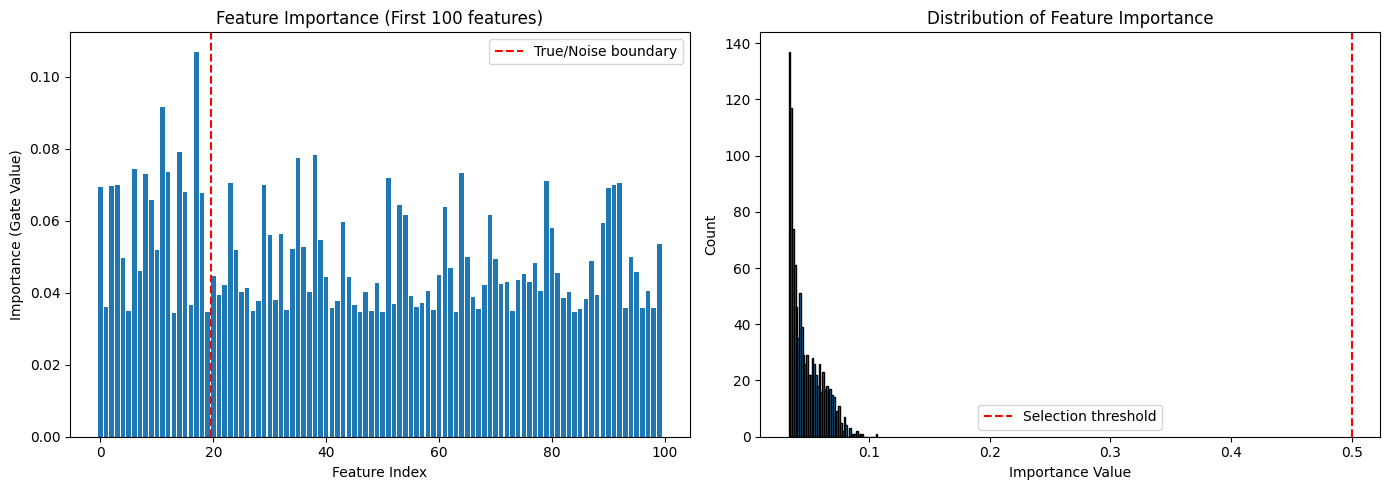

In [4]:
# Analyze selected features
model.eval()
importance = feature_gate.get_feature_importance()
top_30_indices = torch.topk(importance, 30).indices.cpu().numpy()

print(f"\nTop 30 selected features:")
print(f"True informative features in top 30: {sum(i < n_informative for i in top_30_indices)}/{n_informative}")

# Visualize feature importance
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.bar(range(100), importance[:100].cpu().numpy())
plt.axvline(x=n_informative-0.5, color='r', linestyle='--', label='True/Noise boundary')
plt.xlabel('Feature Index')
plt.ylabel('Importance (Gate Value)')
plt.title('Feature Importance (First 100 features)')
plt.legend()

plt.subplot(1, 2, 2)
# Show importance distribution
plt.hist(importance.cpu().numpy(), bins=50, edgecolor='black')
plt.xlabel('Importance Value')
plt.ylabel('Count')
plt.title('Distribution of Feature Importance')
plt.axvline(x=0.5, color='r', linestyle='--', label='Selection threshold')
plt.legend()

plt.tight_layout()
plt.show()